In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("PS_2026.02.09_09.53.13.csv", comment="#")


Summary Statistics:
       default_flag     sy_snum     sy_pnum    disc_year  pl_controv_flag  \
count         746.0  746.000000  746.000000   745.000000       746.000000   
mean            1.0    1.121984    1.631367  2022.777181         0.004021   
std             0.0    0.355020    1.069169     1.783667         0.063330   
min             1.0    1.000000    1.000000  2018.000000         0.000000   
25%             1.0    1.000000    1.000000  2022.000000         0.000000   
50%             1.0    1.000000    1.000000  2023.000000         0.000000   
75%             1.0    1.000000    2.000000  2024.000000         0.000000   
max             1.0    3.000000    6.000000  2026.000000         1.000000   

        pl_orbper  pl_orbpererr1  pl_orbpererr2  pl_orbperlim  pl_orbsmax  \
count  743.000000   7.230000e+02   7.230000e+02         743.0  652.000000   
mean    13.874506   1.965765e-03  -1.787445e-03           0.0    0.090386   
std     30.385708   2.664913e-02   2.449135e-02       

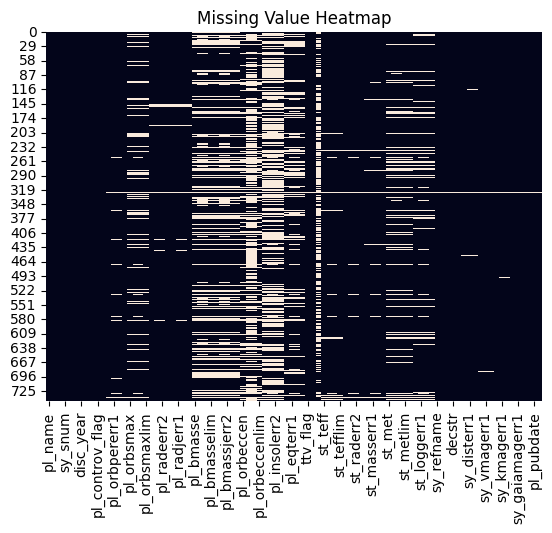

In [8]:
# 3. DATA QUALITY ASSESSMENT
# ==============================

# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

# Missing Values Count
print("\nMissing Values:")
print(df.isnull().sum())

# Missing Value Heatmap
plt.figure()
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [10]:
# 4. HANDLING MISSING DATA
# ==============================

# Separate feature types
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Planetary physical values → Median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical → Mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove completely empty rows
df.dropna(how='all', inplace=True)

In [12]:
# 5. OUTLIER DETECTION
# ==============================

# Z-score method
z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]

# IQR method
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) |
          (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Shape after Outlier Removal:", df.shape)


Shape after Outlier Removal: (0, 92)


In [13]:
# 6. REMOVE PHYSICALLY IMPOSSIBLE VALUES
# ==============================

if 'planet_radius' in df.columns:
    df = df[df['planet_radius'] > 0]

if 'equilibrium_temperature' in df.columns:
    df = df[df['equilibrium_temperature'] > 0]


In [14]:
# 7. UNIT STANDARDIZATION
# ==============================

# Convert Radius to Earth radii (if in km)
if 'planet_radius_km' in df.columns:
    df['planet_radius'] = df['planet_radius_km'] / 6371

# Convert Mass to Earth masses
if 'planet_mass_kg' in df.columns:
    df['planet_mass'] = df['planet_mass_kg'] / 5.972e24

# Convert Distance to AU (if in km)
if 'semi_major_axis_km' in df.columns:
    df['semi_major_axis'] = df['semi_major_axis_km'] / 1.496e8

# Convert Temperature to Kelvin (if Celsius)
if 'temperature_c' in df.columns:
    df['equilibrium_temperature'] = df['temperature_c'] + 273.15


In [16]:
# 8. FEATURE ENGINEERING
# ==============================

# 1️⃣ Habitability Score Index
if set(['equilibrium_temperature', 'planet_radius',
        'semi_major_axis', 'star_luminosity']).issubset(df.columns):

    temp_score = 1 - abs(df['equilibrium_temperature'] - 288) / 288
    radius_score = 1 - abs(df['planet_radius'] - 1)
    distance_score = 1 - abs(df['semi_major_axis'] - 1)
    luminosity_score = 1 - abs(df['star_luminosity'] - 1)
    df['habitability_index'] = (
        temp_score + radius_score +
        distance_score + luminosity_score
    ) / 4


# 2️⃣ Stellar Compatibility Index
if set(['star_temperature', 'star_luminosity']).issubset(df.columns):
    df['stellar_compatibility'] = (
        df['star_temperature'] * df['star_luminosity']
    ) / df['star_temperature'].max()

    # 3️⃣ Orbital Stability Factor
if set(['orbital_period', 'semi_major_axis']).issubset(df.columns):
    df['orbital_stability'] = (
        df['orbital_period'] / df['semi_major_axis']
    )


In [17]:
# 9. CATEGORICAL ENCODING
# ==============================

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [27]:
import pandas as pd

df = pd.read_csv(
    "PS_2026.02.09_09.53.13.csv",
    sep=",",          # comma separated
    comment="#",
    engine="python"
)

print("Correct Shape:", df.shape)
print(df.head())

Correct Shape: (746, 92)
          pl_name      hostname  default_flag  sy_snum  sy_pnum  \
0        AU Mic b        AU Mic             1        1        4   
1        AU Mic c        AU Mic             1        1        4   
2  BD+05 4868 A b  BD+05 4868 A             1        2        1   
3    BD-14 3065 b  BD-14 3065 A             1        3        1   
4      DS Tuc A b      DS Tuc A             1        2        1   

  discoverymethod  disc_year                                 disc_facility  \
0         Transit     2020.0  Transiting Exoplanet Survey Satellite (TESS)   
1         Transit     2021.0  Transiting Exoplanet Survey Satellite (TESS)   
2         Transit     2025.0  Transiting Exoplanet Survey Satellite (TESS)   
3         Transit     2024.0  Transiting Exoplanet Survey Satellite (TESS)   
4         Transit     2019.0  Transiting Exoplanet Survey Satellite (TESS)   

               soltype  pl_controv_flag  ... sy_vmagerr2  sy_kmag  \
0  Published Confirmed            

In [28]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numeric Columns:", len(num_cols))

Numeric Columns: 76


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Scaling completed successfully")

Scaling completed successfully


In [33]:
df_scaled = df.copy()

In [34]:
# 11. TARGET VARIABLE CREATION
# ==============================

# Binary Classification Example
if 'habitability_index' in df_scaled.columns:
    df_scaled['target'] = np.where(
        df_scaled['habitability_index'] > 0,
        1, 0
    )

In [35]:
# 12. SAVE FINAL DATASET
# ==============================

df_scaled.to_csv("preprocessed.csv", index=False)

print("Final Shape:", df_scaled.shape)
print("Dataset saved as preprocessed.csv")

Final Shape: (746, 92)
Dataset saved as preprocessed.csv
